In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import xgboost as xgb
import seaborn as sns
import matplotlib.pylab as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
df = pd.read_csv('res_sm.csv')

variable_lable = ['金额', '退赃', '自首', '不构成自首', '坦白', '如实供述', '主动交代', '立功',
       '检举查证属实', '揭发', '立功不予采纳', '认罪态度良好', '认罪认罚', '当庭认罪', '悔罪', '多次索贿',
       '致使公共财产、国家和人民利益遭受损失', '为他人谋取职务提拔、调整', '曾因受过处分', '曾因*罪', '赃款赃物用于非法活动',
       '无法追缴', '造成恶劣影响', '造成严重后果', '通过其他国家工作人员职务上的行为']

output_lable = ['有期徒刑', '缓刑', '罚金']
output_lable = ['有期徒刑']

idx1 = np.logical_and(30000 < df['金额'].values,df['金额'].values <= 200000)
idx2 = np.logical_and(200000 < df['金额'].values,df['金额'].values <= 3000000)
idx3 = np.logical_and(3000000 < df['金额'].values,df['金额'].values <= np.inf)
idx_t = df['时间'].values>=2016
df = df[idx_t]

df.fillna(0,inplace=True)
variable = df.loc[:,variable_lable].astype(np.float32)
output = df.loc[:,output_lable].astype(np.float32)


In [3]:
feature_num = len(variable_lable)
lable_num = len(output_lable)

class Net(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.lin1 = nn.Linear(feature_num, 128)
        self.lin2 = nn.Linear(128, 16)
        self.lin3 = nn.Linear(16, lable_num)
    
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x
    
    def train(self, train_loader,epoch=100):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        for i in range(epoch):
            for x, y in train_loader:
                y_pred = self.forward(x)
                loss = criterion(y_pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if i%10 == 0:
                print(f'epoch:{i}, loss:{loss.item()}')

train_idx = np.random.choice(len(variable), int(len(variable)*0.8), replace=False)
test_idx = np.array(list(set(range(len(variable))) - set(train_idx)))

data_train = variable.iloc[train_idx]
lable_train = output.iloc[train_idx]
data_test = variable.iloc[test_idx]
lable_test = output.iloc[test_idx]

# train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(variable[train_idx]), torch.from_numpy(output[train_idx]))
# test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(variable[test_idx]), torch.from_numpy(output[test_idx]))

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# net = Net()

# net.train(train_loader)

import matplotlib.pylab as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']


205.64125 137.81194


C:\Users\17473\AppData\Local\Temp\ipykernel_26452\616159463.py:30: RuntimeWarning: divide by zero encountered in true_divide
  diff_train = (lable_train.values.flatten()-pre_train.flatten())/lable_train.values.flatten()
C:\Users\17473\AppData\Local\Temp\ipykernel_26452\616159463.py:31: RuntimeWarning: divide by zero encountered in true_divide
  diff_test = (lable_test.values.flatten()-pre_test.flatten())/lable_test.values.flatten()


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

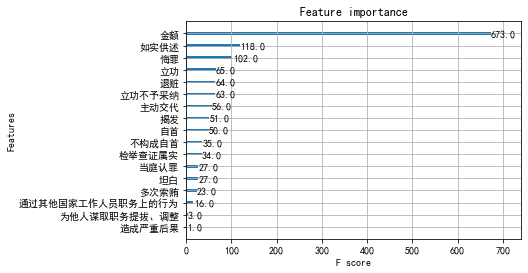

In [19]:
model = xgb.XGBRegressor(max_depth = 5, n_estimators = 100, learning_rate = 0.1)

dtrain = xgb.DMatrix(data_train, label=lable_train)

params = {
    'booster': 'gbtree',
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 8,
    'eval_metric': 'rmse',
    'verbosity':1,
}

model = xgb.train(params,dtrain,100)

from sklearn.metrics import mean_squared_error

pre_test = model.predict(xgb.DMatrix(data_test))
msetest = mean_squared_error(lable_test.values.flatten(),pre_test.flatten())

pre_train = model.predict(xgb.DMatrix(data_train))
msetrain = mean_squared_error(lable_train.values.flatten(),pre_train.flatten())

diff_train = (lable_train.values.flatten()-pre_train.flatten())/lable_train.values.flatten()
diff_test = (lable_test.values.flatten()-pre_test.flatten())/lable_test.values.flatten()
diff_train = diff_train[~np.isnan(diff_train)]
diff_test = diff_test[~np.isnan(diff_test)]
diff_train = diff_train[~np.isinf(diff_train)]
diff_test = diff_test[~np.isinf(diff_test)]
diff_train = diff_train[np.abs(diff_train-diff_train.mean())<3*diff_train.std()]
diff_test = diff_test[np.abs(diff_test-diff_test.mean())<3*diff_test.std()]


print(msetest,msetrain)

xgb.plot_importance(model)

0.38431317


<AxesSubplot:ylabel='Count'>

C:\Users\17473\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


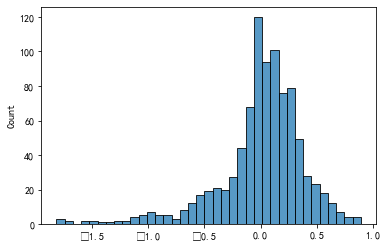

In [20]:
print(diff_train.std())
sns.histplot(diff_train)

0.5278642


<AxesSubplot:ylabel='Count'>

C:\Users\17473\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


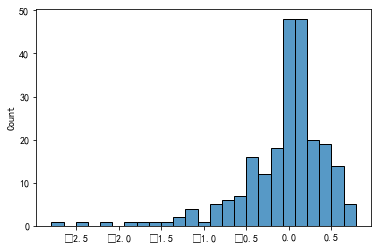

In [21]:
print(diff_test.std())
sns.histplot(diff_test)

array([[1.        , 0.64032545],
       [0.64032545, 1.        ]])

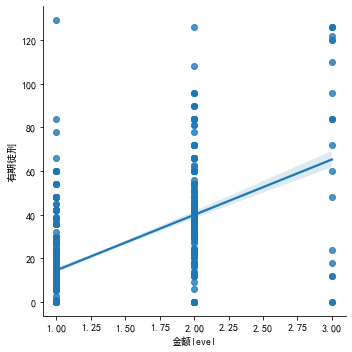

In [7]:

idx = df['金额'].values<df['金额'].mean()+3*df['金额'].std()
df = df[idx]
df['金额level'] = df['金额'].apply(lambda x: 1 if x<200000 else 2 if x<3000000 else 3)
sns.lmplot(x='金额level',y='有期徒刑',data=df)

np.corrcoef(df['金额level'].values,df['有期徒刑'].values)


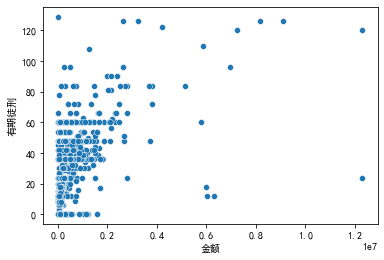

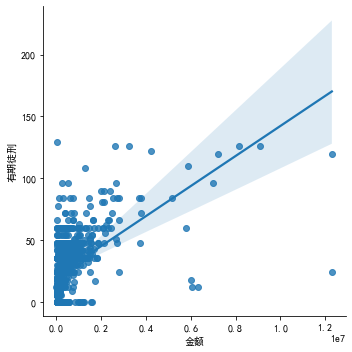

In [8]:
df.drop(df[np.logical_and(df['有期徒刑']<10,df['金额']>3e6)].index,inplace=True)
sns.scatterplot(x='金额',y='有期徒刑',data=df)
sns.lmplot(x='金额',y='有期徒刑',data=df)

<AxesSubplot:xlabel='金额level', ylabel='有期徒刑'>

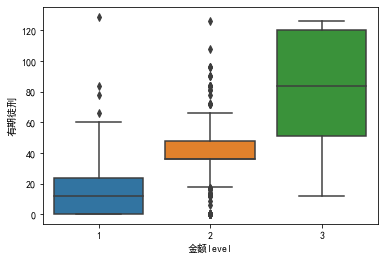

In [9]:
sns.boxplot(x=df['金额level'],y=df['有期徒刑'])

In [10]:
print(len(df))

1365
